# Задание 3

In [1]:
#!pip install -q catalyst

In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

C:\Users\user0\anaconda3\envs\custom\lib\site-packages\catalyst\registry\registry.py:42: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  class Registry(collections.MutableMapping):
C:\Users\user0\anaconda3\envs\custom\lib\site-packages\tensorboardX\proto\resource_handle_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\user0\anaconda3\envs\custom\lib\site-packages\tensorboardX\proto\resource_handle_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [3]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            # self.bias_term = nn.Parameter(torch.randn(out_features))
            self.bias_term = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x =  x.mm(self.weights)
        if self.bias:
            x +=  self.bias_term
        return x

C:\Users\user0\anaconda3\envs\custom\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

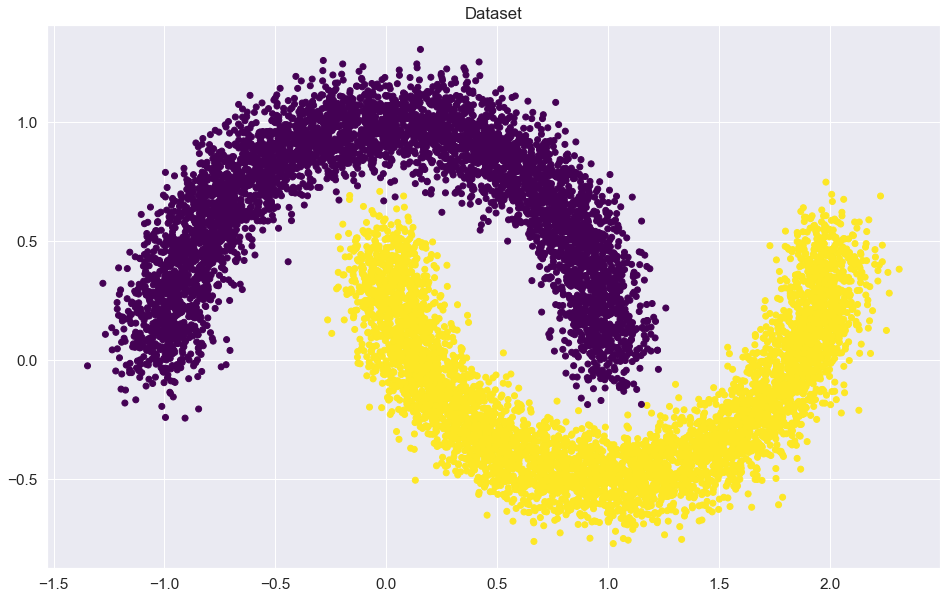

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [7]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [9]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:**

In [10]:
2 * 1 + 1

3

In [11]:
from torchsummary import summary
summary(linear_regression, (2,), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
└─LinearRegression: 0-1                  [-1, 1]                   3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
└─LinearRegression: 0-1                  [-1, 1]                   3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        y_batch = y_batch.view(-1, 1)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}. Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 62.71875
Iteration: 7500
Batch accuracy: 63.75
Iteration: 15000
Batch accuracy: 63.9375
Iteration: 22500
Batch accuracy: 63.96875
Iteration: 30000
Batch accuracy: 64.03125
Iteration: 37500
Batch accuracy: 64.03125
Iteration: 45000
Batch accuracy: 64.03125
Iteration: 52500
Batch accuracy: 64.03125
Iteration: 60000
Batch accuracy: 64.03125
Iteration: 67500
Batch accuracy: 64.03125
Iteration: 75000
Batch accuracy: 64.03125
Iteration: 82500
Batch accuracy: 64.03125
Iteration: 90000
Batch accuracy: 64.03125

Iteration: 90051. Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**
90051

### Визуализируем результаты

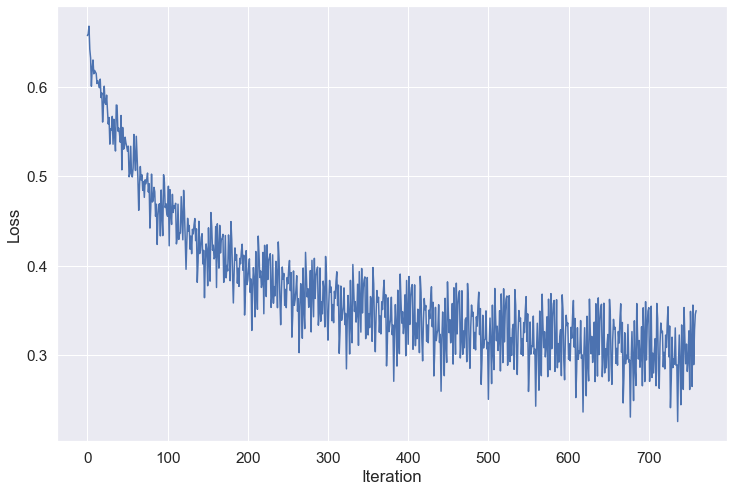

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

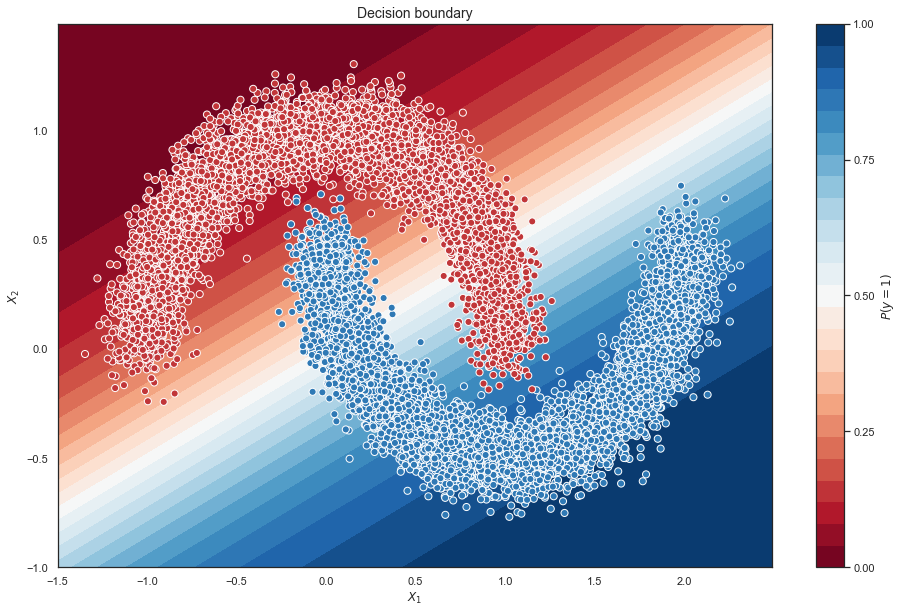

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch)).numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-0.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([], dtype='int64')
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions

In [16]:
from sklearn.metrics import accuracy_score

y_predict = predict(val_dataloader, linear_regression)
accuracy_score(y_val, y_predict)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**
0.862

### MNIST

In [17]:
import os
from catalyst.contrib.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

BATCH_SIZE = 128

train_dataset = MNIST(root=os.getcwd(), train=True, download=True, transform=transform)
val_dataset = MNIST(root=os.getcwd(), train=False, transform=transform)
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

C:\Users\user0\anaconda3\envs\custom\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [18]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [34]:
# activation = Identical
# activation = nn.ReLU
# activation = nn.LeakyReLU
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [37]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model = model.to(device)
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 outp = model(x_batch.to(device))
                #  print(outp.shape, y_batch.shape)
                 optimizer.zero_grad()
                 loss = criterion(outp, y_batch.to(device))
                 loss.backward()
                 optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad():
                     outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #      # YOUR CODE GOES HERE
            #      # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8895833333333333
Loader: valid. Accuracy: 0.8951571428571429
Epoch: 2
Loader: train. Accuracy: 0.9433166666666667
Loader: valid. Accuracy: 0.9443428571428572
Epoch: 3
Loader: train. Accuracy: 0.9596
Loader: valid. Accuracy: 0.9599
Epoch: 4
Loader: train. Accuracy: 0.9693833333333334
Loader: valid. Accuracy: 0.9691285714285715
Epoch: 5
Loader: train. Accuracy: 0.97535
Loader: valid. Accuracy: 0.9745857142857143
Epoch: 6
Loader: train. Accuracy: 0.9801666666666666
Loader: valid. Accuracy: 0.9788142857142857
Epoch: 7
Loader: train. Accuracy: 0.9839333333333333
Loader: valid. Accuracy: 0.9819714285714286
Epoch: 8
Loader: train. Accuracy: 0.9871833333333333
Loader: valid. Accuracy: 0.9848
Epoch: 9
Loader: train. Accuracy: 0.9896166666666667
Loader: valid. Accuracy: 0.987
Epoch: 10
Loader: train. Accuracy: 0.9920166666666667
Loader: valid. Accuracy: 0.9893857142857143


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [23]:
plain_accuracy = accuracy["valid"].copy()

In [28]:
relu_accuracy = accuracy["valid"].copy()

In [33]:
leaky_relu_accuracy = accuracy["valid"].copy()

In [38]:
elu_accuracy = accuracy["valid"].copy()

### Accuracy

In [39]:
print(plain_accuracy[-1], relu_accuracy[-1], leaky_relu_accuracy[-1], elu_accuracy[-1], sep='\n')

0.9218857142857143
0.9902
0.9902714285714286
0.9893857142857143


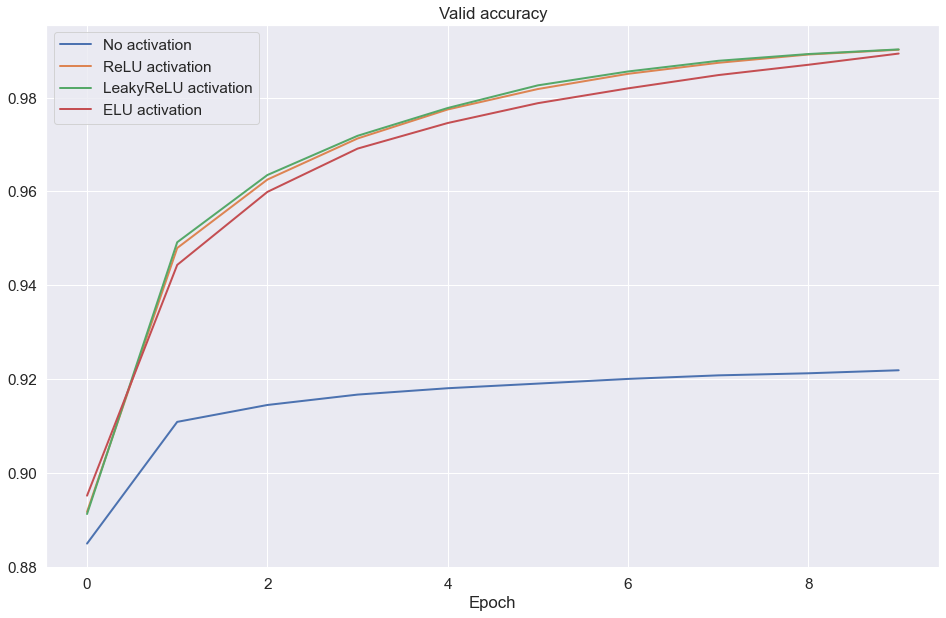

In [40]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** ReLU

## Сверточные слои

### Ядра

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

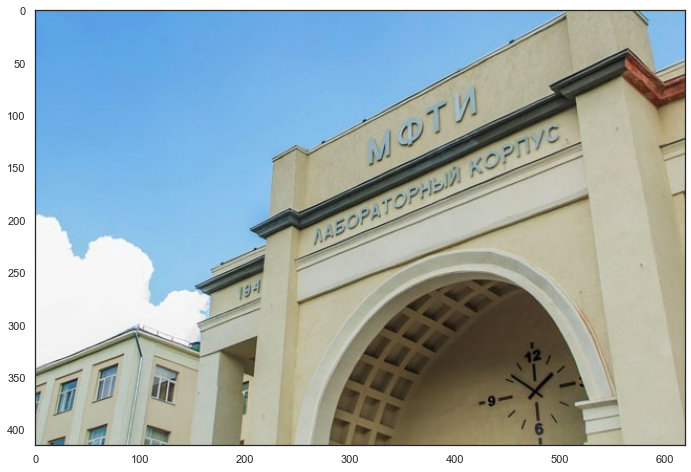

In [41]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [42]:
img_t = torch.from_numpy(RGB_img).type(torch.float32)
print('img_t', img_t.shape)
img_t = img_t.unsqueeze(0)
print('img_t', img_t.shape)
kernel = torch.tensor([
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

print('kernel', kernel.shape)
kernel = kernel.repeat(3, 3, 1, 1)
print('kernel', kernel.shape)
print('img_t', img_t.shape)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
print('img_t', img_t.shape)
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
print('img_t', img_t.shape)

result = F.conv2d(img_t, kernel)[0]  #
print('result', result.shape)

img_t torch.Size([415, 620, 3])
img_t torch.Size([1, 415, 620, 3])
kernel torch.Size([1, 1, 3, 3])
kernel torch.Size([3, 3, 3, 3])
img_t torch.Size([1, 415, 620, 3])
img_t torch.Size([1, 3, 415, 620])
img_t torch.Size([1, 3, 417, 622])
result torch.Size([3, 415, 620])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


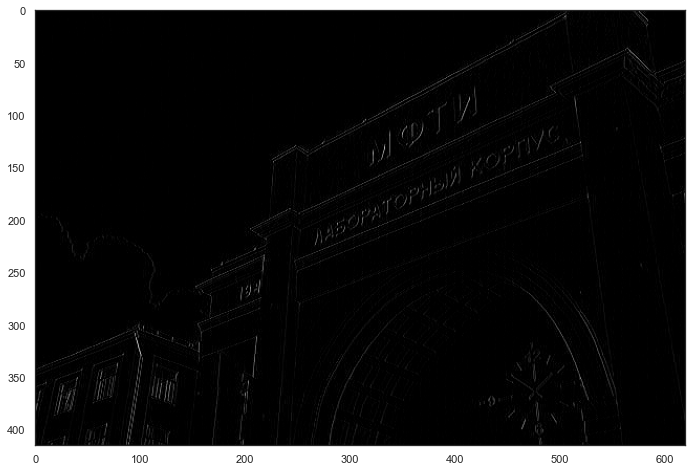

In [43]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [46]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                outp = model(x_batch.to(device))
                optimizer.zero_grad()
                # print(outp.shape, y_batch.shape)
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct =  (preds == y_batch.to(device)).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #      # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8517666666666667
Loader: valid. Accuracy: 0.8662142857142857
Epoch: 2
Loader: train. Accuracy: 0.9584333333333334
Loader: valid. Accuracy: 0.9600428571428572
Epoch: 3
Loader: train. Accuracy: 0.97095
Loader: valid. Accuracy: 0.9715
Epoch: 4
Loader: train. Accuracy: 0.9777333333333333
Loader: valid. Accuracy: 0.9778857142857142
Epoch: 5
Loader: train. Accuracy: 0.9819666666666667
Loader: valid. Accuracy: 0.9819857142857142
Epoch: 6
Loader: train. Accuracy: 0.9845
Loader: valid. Accuracy: 0.9842285714285715
Epoch: 7
Loader: train. Accuracy: 0.9866166666666667
Loader: valid. Accuracy: 0.9861285714285715
Epoch: 8
Loader: train. Accuracy: 0.9888
Loader: valid. Accuracy: 0.9880142857142857
Epoch: 9
Loader: train. Accuracy: 0.9901833333333333
Loader: valid. Accuracy: 0.9892857142857143
Epoch: 10
Loader: train. Accuracy: 0.9915333333333334
Loader: valid. Accuracy: 0.9905


In [47]:
lenet_accuracy = accuracy["valid"].copy()

Сравним с предыдущем пунктом

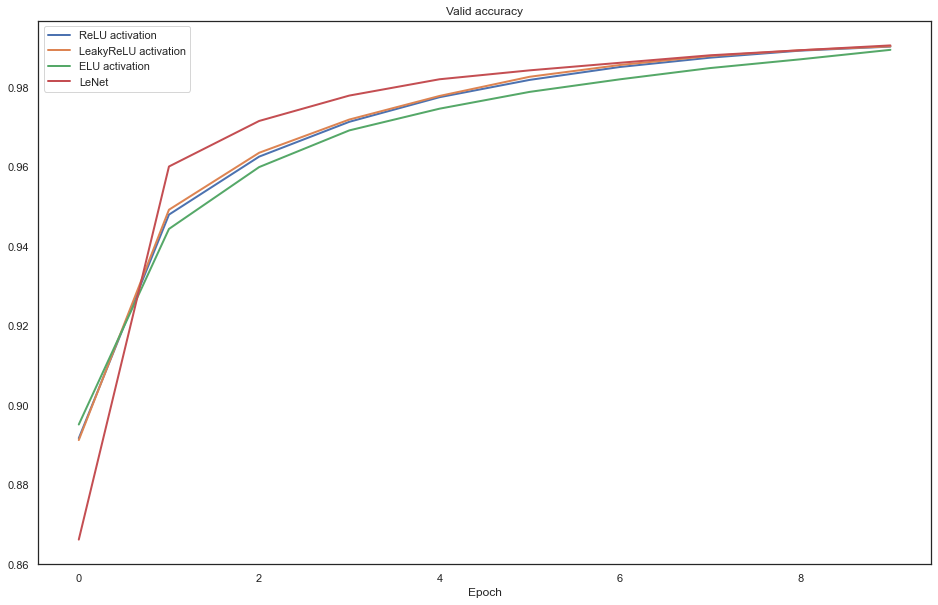

In [48]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99

In [49]:
round(lenet_accuracy[-1], 2)

0.99